In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
adata = sc.read_h5ad('../data/mtDNA_DSB_5k_clustered_LLM_anno.h5ad')

In [3]:
sample_annotations_balanced = {
    "RB4282": "DSB",
    "RB4403": "DSB",
    "RB4405": "DSB",
    "RB4350": "DSB",
    "RB4498": "DSB",
    "RB4630": "DSB",
    "RB4620": "Control",
    "RB4627": "Control",
    "RB4676": "Control",
    "RB4653": "Control",
    "RB4658": "Control",
    "RB4401": "Control"
}

In [4]:
adata.obs["condition_predicted"] = adata.obs["sample_id"].map(sample_annotations_balanced)

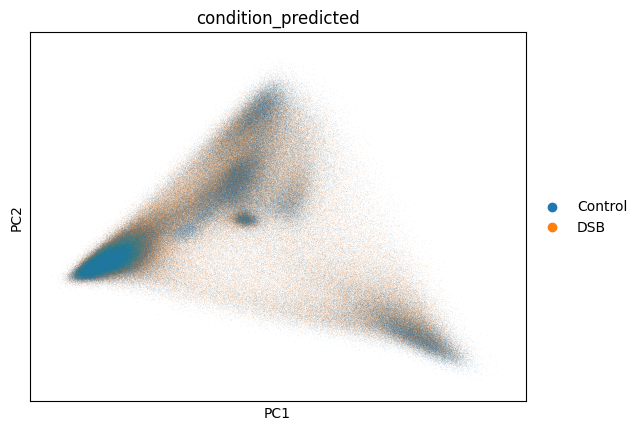

In [5]:
sc.pl.pca(adata, color="condition_predicted")

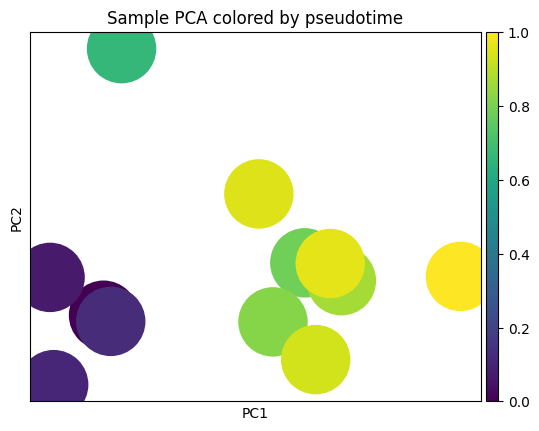

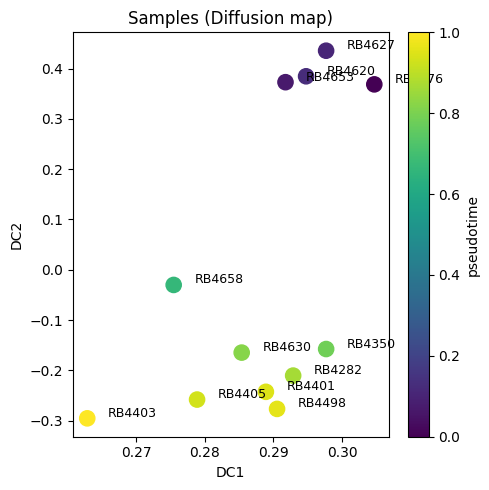


Root sample (control-like): RB4676
Samples ordered by pseudotime (early → late):
['RB4676', 'RB4653', 'RB4627', 'RB4620', 'RB4658', 'RB4350', 'RB4630', 'RB4282', 'RB4405', 'RB4401', 'RB4498', 'RB4403']

Spearman correlations with pseudotime:
  stress_score: r=0.769, p=0.00345
  myelin_score: r=-0.217, p=0.499


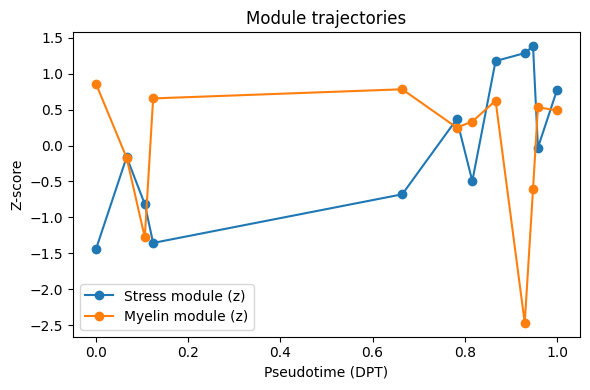

In [6]:
# === Sample-level pseudotime (blinded) for OL data ===
# Requirements: scanpy >=1.9, pandas, numpy, matplotlib, scipy

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ---------- 0) Inputs ----------
# Assumes your AnnData is `adata` and has adata.obs["sample_id"].
# (Subset to OLs beforehand if desired.)

# Define marker modules (edit if you like)
stress_genes = [
    "Sgk1","Ddit4","Tsc22d3","Pink1","Mt2",
    "Hspa1a","Hspa1b","Hsph1","Dnajb1","Atf4","Atf5","Ldha","Serpina3n"
]
myelin_genes = [
    "Mbp","Mog","Mag","Cnp","Cldn11","Mal","Ermn",
    "Pllp","Aspa","Ugt8a","Ptgds","Car2","Sept4"
]

def safe_mean(df, genes):
    """Mean across genes present in df (samples x genes)."""
    g = [g for g in genes if g in df.columns]
    if not g:
        return pd.Series(0.0, index=df.index)
    return df[g].mean(axis=1)

# ---------- 1) Pseudobulk by sample ----------
# Average expression per sample; you can use .sum() for counts if preferred.
pb = adata.to_df().groupby(adata.obs["sample_id"]).mean()
sample_ids = pb.index.tolist()

# ---------- 2) Build samples×genes AnnData ----------
adata_pb = sc.AnnData(pb.values)
adata_pb.obs.index = sample_ids
adata_pb.var.index = pb.columns

# ---------- 3) Dimensionality reduction & pseudotime ----------
# Scale at the sample level
sc.pp.scale(adata_pb, max_value=10)
sc.tl.pca(adata_pb, n_comps=min(10, adata_pb.n_vars))
sc.pp.neighbors(adata_pb,
                n_neighbors=max(2, min(6, adata_pb.n_obs - 1)),
                n_pcs=min(10, adata_pb.obsm["X_pca"].shape[1]))
sc.tl.diffmap(adata_pb)

# Compute module summaries on *unscaled* pb to choose a root (control-like)
stress_score_pb = safe_mean(pb, stress_genes)
myelin_score_pb = safe_mean(pb, myelin_genes)
root_sample = (stress_score_pb - myelin_score_pb).idxmin()  # lowest stress - myelin
root_index  = list(adata_pb.obs_names).index(root_sample)

# Set root BEFORE DPT
adata_pb.uns["iroot"] = root_index
sc.tl.dpt(adata_pb, n_dcs=5)  # pseudotime in adata_pb.obs["dpt_pseudotime"]

# ---------- 4) Plots ----------
# PCA colored by pseudotime
sc.pl.pca(adata_pb, color="dpt_pseudotime", title="Sample PCA colored by pseudotime")

# Diffusion map scatter (DC1 vs DC2) with labels + colorbar
dc = adata_pb.obsm["X_diffmap"][:, :2]
pt = adata_pb.obs["dpt_pseudotime"]
plt.figure(figsize=(5,5))
scat = plt.scatter(dc[:,0], dc[:,1], c=pt, s=120, cmap="viridis")
for i, sid in enumerate(adata_pb.obs_names):
    plt.text(dc[i,0] + 0.003, dc[i,1] + 0.003, sid, fontsize=9)
plt.xlabel("DC1"); plt.ylabel("DC2"); plt.title("Samples (Diffusion map)")
cbar = plt.colorbar(scat); cbar.set_label("pseudotime")
plt.tight_layout(); plt.show()

# ---------- 5) Summaries & quick stats ----------
summary = pd.DataFrame({
    "sample_id": adata_pb.obs_names,
    "pseudotime": pt.values,
    "stress_score": stress_score_pb.loc[adata_pb.obs_names].values,
    "myelin_score": myelin_score_pb.loc[adata_pb.obs_names].values
}).set_index("sample_id").sort_values("pseudotime")

print("\nRoot sample (control-like):", root_sample)
print("Samples ordered by pseudotime (early → late):")
print(list(summary.index))

print("\nSpearman correlations with pseudotime:")
for name in ["stress_score","myelin_score"]:
    r, p = spearmanr(summary["pseudotime"], summary[name])
    print(f"  {name}: r={r:.3f}, p={p:.3g}")

# ---------- 6) Module trajectories along pseudotime ----------
plt.figure(figsize=(6,4))
z_stress = (summary["stress_score"] - summary["stress_score"].mean())/summary["stress_score"].std()
z_myelin = (summary["myelin_score"] - summary["myelin_score"].mean())/summary["myelin_score"].std()
plt.plot(summary["pseudotime"], z_stress, marker="o", label="Stress module (z)")
plt.plot(summary["pseudotime"], z_myelin, marker="o", label="Myelin module (z)")
plt.xlabel("Pseudotime (DPT)"); plt.ylabel("Z-score"); plt.title("Module trajectories")
plt.legend(); plt.tight_layout(); plt.show()

# (Optional) export
# summary.to_csv("sample_pseudotime_summary.csv")
# adata_pb.write_h5ad("samples_pseudotime.h5ad", compression="gzip")

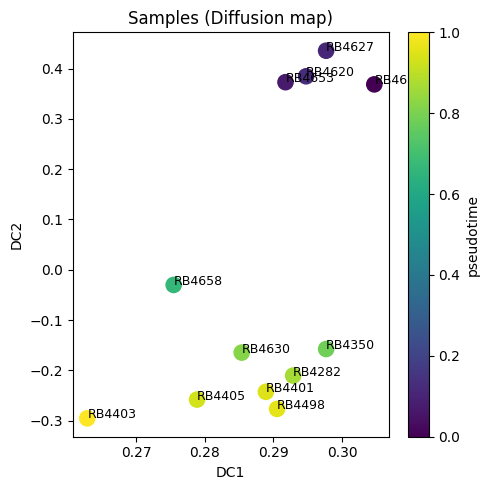

In [39]:

# Diffusion map scatter (DC1 vs DC2) with labels + colorbar
dc = adata_pb.obsm["X_diffmap"][:, :2]
pt = adata_pb.obs["dpt_pseudotime"]
plt.figure(figsize=(5,5))
scat = plt.scatter(dc[:,0], dc[:,1], c=pt, s=120, cmap="viridis")
for i, sid in enumerate(adata_pb.obs_names):
    plt.text(dc[i,0] + 0, dc[i,1] + 0, sid, fontsize=9)
plt.xlabel("DC1"); plt.ylabel("DC2"); plt.title("Samples (Diffusion map)")
cbar = plt.colorbar(scat); cbar.set_label("pseudotime")
plt.tight_layout(); plt.show()

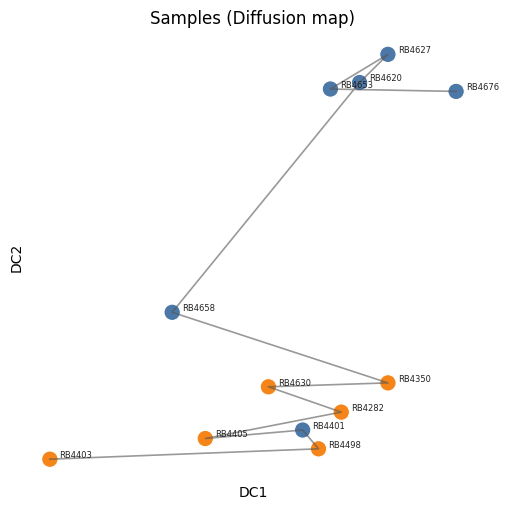

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- inputs ---
X = adata_pb.obsm["X_diffmap"][:, :2]
pt = adata_pb.obs["dpt_pseudotime"].astype(float)
samples = adata_pb.obs_names.to_list()

# OPTIONAL: color by condition if you have it
# sample_annotations_balanced = {...}
cond = pd.Series(
    {s: sample_annotations_balanced.get(s, "Unknown") for s in samples}
).reindex(samples)

# order along pseudotime for the path
order = np.argsort(pt.values)

# --- styling helpers ---
def despine(ax):
    for sp in ["top","right","left","bottom"]:
        ax.spines[sp].set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# --- plot ---
fig, ax = plt.subplots(figsize=(5.2, 5.2))

# choose colors: by pseudotime (continuous) OR by condition (categorical)
color_by_condition = True  # set False to color by pseudotime

if color_by_condition:
    palette = {"Control":"#4C78A8", "mtDSB":"#F58518", "Unknown":"#7F7F7F"}
    colors = cond.map(palette).values
    sc = ax.scatter(X[:,0], X[:,1], s=140, c=colors, edgecolor="white", linewidth=0.8)
else:
    sc = ax.scatter(X[:,0], X[:,1], s=140, c=pt, cmap="viridis",
                    edgecolor="white", linewidth=0.8)
    cbar = plt.colorbar(sc, ax=ax, pad=0.01, fraction=0.04)
    cbar.set_label("pseudotime", rotation=270, labelpad=12)

# connect samples in pseudotime order (nice for trajectory feel)
ax.plot(X[order,0], X[order,1], lw=1.2, alpha=0.6, color="#555555")

# labels with small offset to reduce overlap
for i, sid in enumerate(samples):
    ax.text(X[i,0]+0.001, X[i,1]+0.004, sid, fontsize=6, weight="medium", color="#222")

ax.set_xlabel("DC1"); ax.set_ylabel("DC2")
ax.set_title("Samples (Diffusion map)", pad=8)
despine(ax)
plt.tight_layout()
plt.show()

In [9]:
adata_pb.obs["stress_score"] = stress_score_pb.loc[adata_pb.obs_names].values
adata_pb.obs["myelin_score"] = myelin_score_pb.loc[adata_pb.obs_names].values

In [10]:
# correlations between pseudotime and modules
pt = adata_pb.obs['dpt_pseudotime']
from scipy.stats import spearmanr, kendalltau

for name, vec in {"Stress": adata_pb.obs["stress_score"],
                  "Myelin": adata_pb.obs["myelin_score"]}.items():
    print(name, "Spearman r, p=", spearmanr(pt, vec))
    print(name, "Kendall tau, p=", kendalltau(pt, vec))

Stress Spearman r, p= SignificanceResult(statistic=0.7692307692307694, pvalue=0.0034464502618274493)
Stress Kendall tau, p= SignificanceResult(statistic=0.606060606060606, pvalue=0.005380307706696595)
Myelin Spearman r, p= SignificanceResult(statistic=-0.21678321678321683, pvalue=0.49855598552418856)
Myelin Kendall tau, p= SignificanceResult(statistic=-0.1515151515151515, pvalue=0.5452047007776174)


In [11]:
# top loadings on DC1 (or PC1 if you used PCA)
dc1 = pd.Series(adata_pb.obsm['X_diffmap'][:,0], index=adata_pb.obs_names)
# already computed stress/myelin lists earlier; you can also get per-gene correlations:
mean_expr = pb  # samples x genes (unscaled)
cors = mean_expr.apply(lambda g: spearmanr(pt, g)[0], axis=0).sort_values()
print("Most decreasing along time:", cors.head(15).index.tolist())
print("Most increasing along time:", cors.tail(15).index.tolist())

Most decreasing along time: ['Pald1', 'Pcnt', 'Brd8', 'Kcnq1', 'Sema4g', 'Pbrm1', 'Mlh1', 'Sptlc2', 'Cd3eap', 'Patz1', 'Ikbkb', 'Psma4', 'Ankrd11', 'Kat6a', 'Wwox']
Most increasing along time: ['Dbx2', 'Csde1', 'Ppara', 'Sept9', 'March5', 'Sod2', 'Limk1', 'Fam210a', 'Zbtb7a', 'Slc8a1', 'Rbm8a', 'Gmfb', 'Snx5', 'Ubac1', 'Pgk1']


In [31]:
order = ['RB4676', 'RB4653', 'RB4627', 'RB4620', 'RB4658', 'RB4350', 'RB4630', 'RB4282', 'RB4405', 'RB4401', 'RB4498', 'RB4403']
mapped = [sample_annotations_balanced[s] for s in order]
print(order)
print(mapped)

['RB4676', 'RB4653', 'RB4627', 'RB4620', 'RB4658', 'RB4350', 'RB4630', 'RB4282', 'RB4405', 'RB4401', 'RB4498', 'RB4403']
['Control', 'Control', 'Control', 'Control', 'Control', 'mtDSB', 'mtDSB', 'mtDSB', 'mtDSB', 'Control', 'mtDSB', 'mtDSB']


In [19]:
sample_annotations_balanced = {
    "RB4282": "mtDSB",
    "RB4403": "mtDSB",
    "RB4405": "mtDSB",
    "RB4350": "mtDSB",
    "RB4498": "mtDSB",
    "RB4630": "mtDSB",
    "RB4620": "Control",
    "RB4627": "Control",
    "RB4676": "Control",
    "RB4653": "Control",
    "RB4658": "Control",
    "RB4401": "Control"
}

In [22]:
from scipy.stats import zscore
# pt: adata_pb.obs["dpt_pseudotime"]
# stress_score_pb, myelin_score_pb from earlier code (Series indexed by sample_id)

df = pd.DataFrame({
    "pt": adata_pb.obs["dpt_pseudotime"],
    "stress": stress_score_pb.loc[adata_pb.obs_names],
    "myelin": myelin_score_pb.loc[adata_pb.obs_names]
}, index=adata_pb.obs_names)

df["dsb_strength"] = zscore(df["pt"]) + zscore(df["stress"]) - zscore(df["myelin"])
print(df.sort_values("dsb_strength", ascending=False))

              pt    stress    myelin  dsb_strength
RB4405  0.930127  0.904773 -1.831041      4.763344
RB4401  0.948104  0.972610 -0.451005      2.967149
RB4403  1.000000  0.541573  0.362569      1.315734
RB4282  0.866898  0.826905  0.463090      1.253169
RB4350  0.782599  0.257757  0.185418      0.580740
RB4498  0.958744 -0.020591  0.395274      0.328048
RB4630  0.816419 -0.348503  0.247225     -0.318977
RB4627  0.105946 -0.574033 -0.948656     -0.809704
RB4658  0.664357 -0.477852  0.580489     -1.374192
RB4653  0.066622 -0.113138 -0.127675     -1.383319
RB4620  0.124054 -0.953726  0.486065     -3.347132
RB4676  0.000000 -1.015776  0.638246     -3.974860


In [26]:
df['condition_pred'] = df.index.map(sample_annotations_balanced)

In [27]:
df

,pt,stress,myelin,dsb_strength,condition_pred
RB4282,0.866898,0.826905,0.463090,1.253169,mtDSB
RB4350,0.782599,0.257757,0.185418,0.580740,mtDSB
RB4401,0.948104,0.972610,-0.451005,2.967149,Control
RB4403,1.000000,0.541573,0.362569,1.315734,mtDSB
RB4405,0.930127,0.904773,-1.831041,4.763344,mtDSB
RB4498,0.958744,-0.020591,0.395274,0.328048,mtDSB
RB4620,0.124054,-0.953726,0.486065,-3.347132,Control
RB4627,0.105946,-0.574033,-0.948656,-0.809704,Control
RB4630,0.816419,-0.348503,0.247225,-0.318977,mtDSB
RB4653,0.066622,-0.113138,-0.127675,-1.383319,Control


In [28]:
sample_annotations_balanced_reanno = {
    "RB4282": "mtDSB",
    "RB4403": "mtDSB",
    "RB4405": "mtDSB",
    "RB4350": "mtDSB",
    "RB4498": "mtDSB",
    "RB4401": "mtDSB",   # switched from Control → mtDSB
    "RB4620": "Control",
    "RB4627": "Control",
    "RB4676": "Control",
    "RB4653": "Control",
    "RB4658": "Control",
    "RB4630": "Control"  # switched from mtDSB → Control
}

In [29]:
df['condition_re_pred'] = df.index.map(sample_annotations_balanced_reanno)

In [30]:
df

,pt,stress,myelin,dsb_strength,condition_pred,condition_re_pred
RB4282,0.866898,0.826905,0.463090,1.253169,mtDSB,mtDSB
RB4350,0.782599,0.257757,0.185418,0.580740,mtDSB,mtDSB
RB4401,0.948104,0.972610,-0.451005,2.967149,Control,mtDSB
RB4403,1.000000,0.541573,0.362569,1.315734,mtDSB,mtDSB
RB4405,0.930127,0.904773,-1.831041,4.763344,mtDSB,mtDSB
RB4498,0.958744,-0.020591,0.395274,0.328048,mtDSB,mtDSB
RB4620,0.124054,-0.953726,0.486065,-3.347132,Control,Control
RB4627,0.105946,-0.574033,-0.948656,-0.809704,Control,Control
RB4630,0.816419,-0.348503,0.247225,-0.318977,mtDSB,Control
RB4653,0.066622,-0.113138,-0.127675,-1.383319,Control,Control


In [32]:
order = ['RB4676', 'RB4653', 'RB4627', 'RB4620', 'RB4658', 'RB4350', 'RB4630', 'RB4282', 'RB4405', 'RB4401', 'RB4498', 'RB4403']
mapped = [sample_annotations_balanced_reanno[s] for s in order]
print(order)
print(mapped)

['RB4676', 'RB4653', 'RB4627', 'RB4620', 'RB4658', 'RB4350', 'RB4630', 'RB4282', 'RB4405', 'RB4401', 'RB4498', 'RB4403']
['Control', 'Control', 'Control', 'Control', 'Control', 'mtDSB', 'Control', 'mtDSB', 'mtDSB', 'mtDSB', 'mtDSB', 'mtDSB']


In [100]:
dict(zip(order,mapped))

{'RB4676': 'Control',
 'RB4653': 'Control',
 'RB4627': 'Control',
 'RB4620': 'Control',
 'RB4658': 'Control',
 'RB4350': 'mtDSB',
 'RB4630': 'Control',
 'RB4282': 'mtDSB',
 'RB4405': 'mtDSB',
 'RB4401': 'mtDSB',
 'RB4498': 'mtDSB',
 'RB4403': 'mtDSB'}

In [47]:
import scanpy as sc

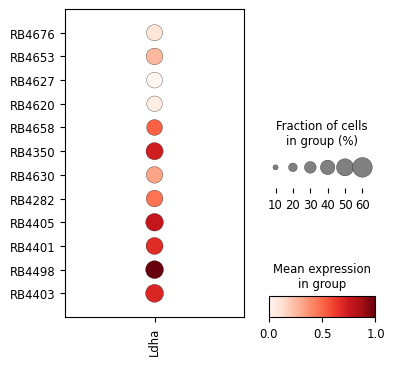

In [103]:
sc.pl.dotplot(
        adata,
        var_names='Ldha',
        groupby="sample_id",
        standard_scale="var",
        #dot_max=0.5,
        #dot_min=0.05,
        color_map="Reds",
        categories_order = order,
        dendrogram=False,
        figsize=(4, 4)
    )

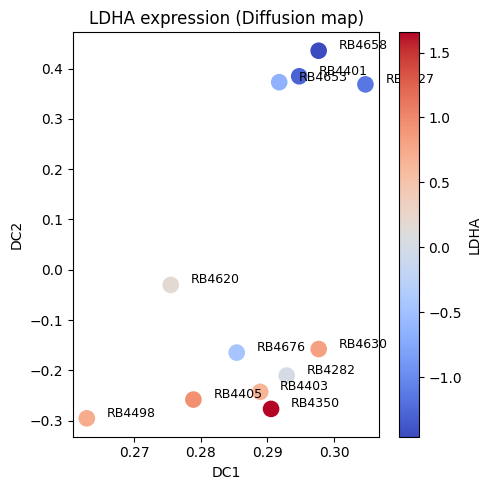

In [105]:
dc = adata_pb.obsm["X_diffmap"][:, :2]
expr = adata_pb[:, "Ldha"].X.flatten()  # or "LDHA"
plt.figure(figsize=(5,5))
sc = plt.scatter(dc[:,0], dc[:,1], c=expr, s=120, cmap="coolwarm")
for i,sid in enumerate(adata_pb.obs_names):
    plt.text(dc[i,0]+0.003, dc[i,1]+0.003, sid, fontsize=9)
plt.xlabel("DC1"); plt.ylabel("DC2"); plt.title("LDHA expression (Diffusion map)")
plt.colorbar(sc, label="LDHA"); plt.tight_layout(); plt.show()

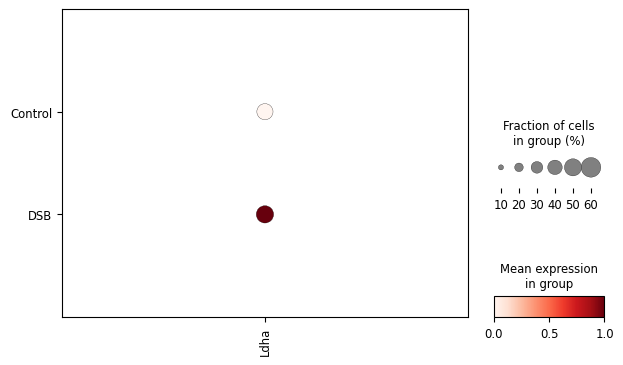

In [49]:
sc.pl.dotplot(
        adata,
        var_names='Ldha',
        groupby="condition_predicted",
        standard_scale="var",
        #dot_max=0.5,
        #dot_min=0.05,
        color_map="Reds",
        
        dendrogram=True,
        figsize=(7, 4)
    )

In [50]:
# pseudobulk as before
pb = adata.to_df().groupby(adata.obs["sample_id"]).mean()

# choose HVGs (optional but recommended)
sc.pp.highly_variable_genes(sc.AnnData(pb.values, var=pd.DataFrame(index=pb.columns)), n_top_genes=2000)

adata_pb = sc.AnnData(pb.values)
adata_pb.obs.index = pb.index
adata_pb.var.index = pb.columns

# standard preprocessing
sc.pp.scale(adata_pb, max_value=10)
sc.tl.pca(adata_pb, n_comps=10)
sc.pp.neighbors(adata_pb, n_neighbors=min(6, adata_pb.n_obs-1), n_pcs=10)
sc.tl.diffmap(adata_pb)

# pick a root automatically (e.g. lowest stress − myelin if you like)
adata_pb.uns['iroot'] = 0   # or use your stress/myelin heuristic
sc.tl.dpt(adata_pb, n_dcs=5)

pt = adata_pb.obs['dpt_pseudotime']

In [51]:
from scipy.stats import spearmanr

results = []
for g in adata_pb.var_names:
    r, p = spearmanr(pt, pb[g])
    results.append((g, r, p))

res_df = pd.DataFrame(results, columns=["gene", "spearman_r", "pval"])
res_df["adj_pval"] = res_df["pval"] * len(res_df)  # Bonferroni correction
res_df = res_df.sort_values("spearman_r", ascending=False)

In [87]:
res_df[res_df.gene == 'Slc16a1']

,gene,spearman_r,pval,adj_pval
4213,Slc16a1,0.748252,0.005124,26.137941


In [88]:
res_df[res_df.gene == 'Slc16a3']

,gene,spearman_r,pval,adj_pval
4215,Slc16a3,0.286713,0.366251,1868.2487


In [80]:
res_df.tail(10)

,gene,spearman_r,pval,adj_pval
1964,Grk2,-0.881119,0.000153,0.778790
2971,Mturn,-0.881119,0.000153,0.778790
3200,Nr2e1,-0.888112,0.000114,0.582195
3226,Nsmf,-0.888112,0.000114,0.582195
2154,Hpcal4,-0.888112,0.000114,0.582195
4423,Spop,-0.902098,0.000060,0.305951
1093,Cxcl14,-0.909091,0.000042,0.213785
4351,Snph,-0.909091,0.000042,0.213785
543,Camk2a,-0.916084,0.000028,0.145011
3473,Pink1,-0.916084,0.000028,0.145011


In [71]:
res_df[res_df.gene == 'Ldha']

,gene,spearman_r,pval,adj_pval
2607,Ldha,-0.615385,0.03317,169.199665


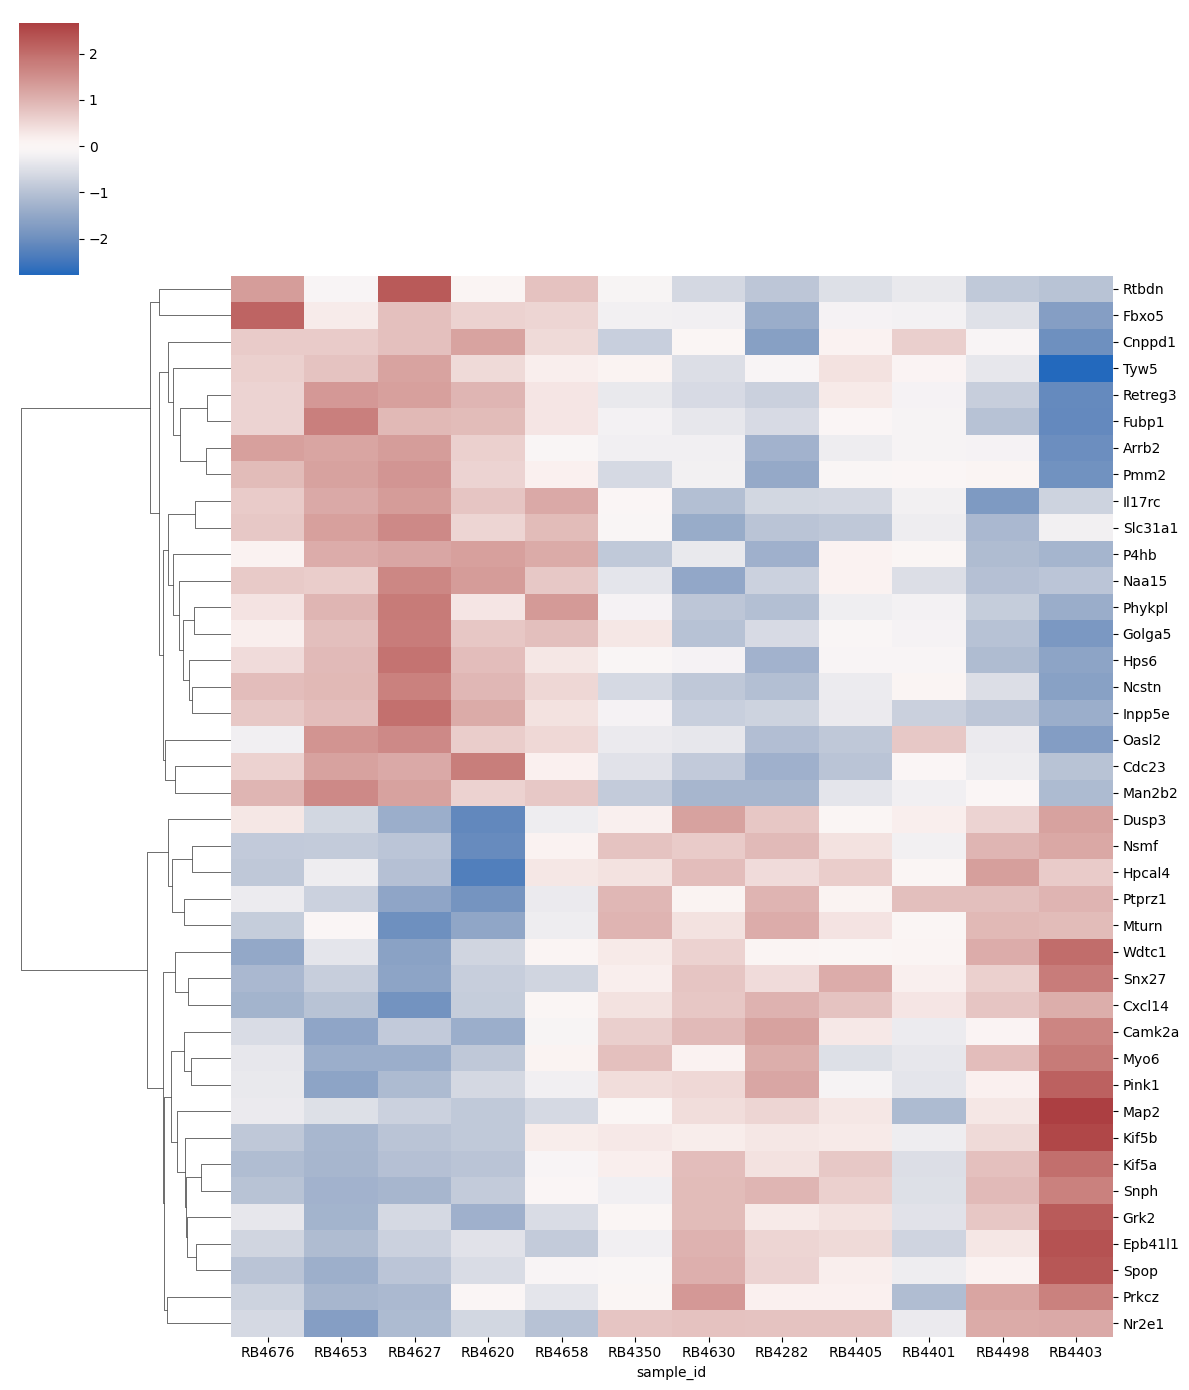

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.clustermap(
    pb_scaled.T,
    col_cluster=False,
    cmap="vlag",
    center=0,
    figsize=(12, 14)
)



In [57]:
order = ['RB4676', 'RB4653', 'RB4627', 'RB4620', 'RB4658', 'RB4350', 'RB4630', 'RB4282', 'RB4405', 'RB4401', 'RB4498', 'RB4403']
mapped = [sample_annotations_balanced_reanno[s] for s in order]
print(order)
print(mapped)

['RB4676', 'RB4653', 'RB4627', 'RB4620', 'RB4658', 'RB4350', 'RB4630', 'RB4282', 'RB4405', 'RB4401', 'RB4498', 'RB4403']
['Control', 'Control', 'Control', 'Control', 'Control', 'mtDSB', 'Control', 'mtDSB', 'mtDSB', 'mtDSB', 'mtDSB', 'mtDSB']


In [82]:
mito_genes_mouse = [
    "Ndufa9","Ndufs1","Sdha","Uqcrc1","Cox4i1","Atp5f1a",
    "Mfn2","Opa1","Dnm1l","Fis1",
    "Ppargc1a","Tfam",
    "Pink1","Prkn","Bnip3",
    "Sod2","Prdx3","Hspa9","Hspd1",
    "Cs","Idh3a","Ogdh","Suclg1","Mdh2","Fh1",
    "Cpt1a","Acadm","Acadvl",
    "Ldha","Ldhb","Slc16a1","Slc16a3"
]

In [83]:
genes_of_interest = set(mito_genes_mouse + stress_genes)

In [84]:
focus_df = res_df[res_df["gene"].isin(genes_of_interest)].copy()

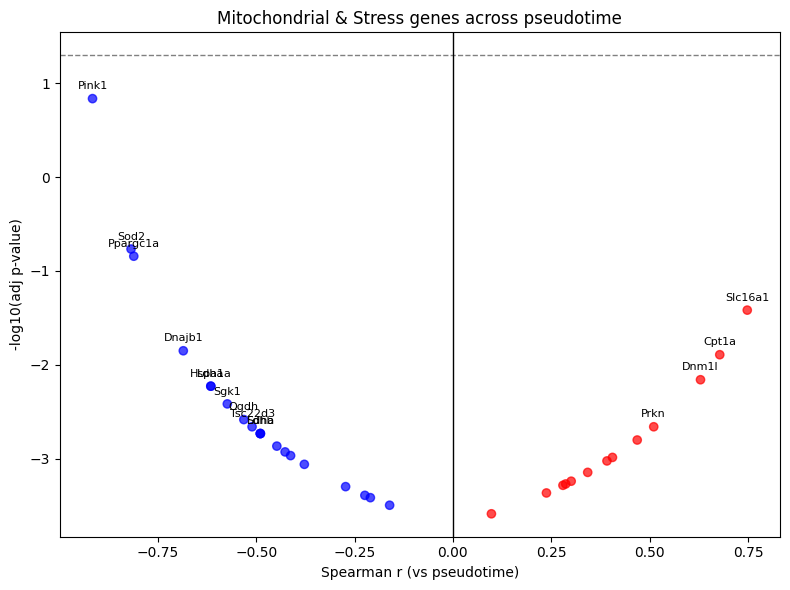

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# –log10 p-values
focus_df["neglog10_pval"] = -np.log10(focus_df["adj_pval"] + 1e-10)

plt.figure(figsize=(8,6))
scat = plt.scatter(
    focus_df["spearman_r"], focus_df["neglog10_pval"],
    c=np.where(focus_df["spearman_r"]>0, "red", "blue"),
    alpha=0.7
)

plt.axhline(-np.log10(0.05), color="grey", linestyle="--", lw=1)
plt.axvline(0, color="black", lw=1)

# Annotate top hits
top_hits = focus_df.sort_values("neglog10_pval", ascending=False).head(15)
for _, row in top_hits.iterrows():
    plt.text(row["spearman_r"], row["neglog10_pval"]+0.1, row["gene"],
             fontsize=8, ha="center")

plt.xlabel("Spearman r (vs pseudotime)")
plt.ylabel("-log10(adj p-value)")
plt.title("Mitochondrial & Stress genes across pseudotime")
plt.tight_layout()
plt.show()